# Material de apoio

## Estatística: probabilidade e amostragem

### Importando as bibliotecas

In [1]:
from lerMicrodados import lerMicrodados
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# binomial
from scipy.special import comb
from scipy.stats import binom
# poisson
from scipy.stats import poisson
# normal
from scipy.stats import norm

### Importando a base de dados

A base de dados pode ser encontrada no link: https://www.ibge.gov.br/estatisticas/sociais/populacao/19897-sintese-de-indicadores-pnad2.html?=&t=microdados
Ou seja, é um conjunto vindo do site do Instituto Brasileiro de Geografia e Estatística (IBGE).

Nesta página do IBGE, encontraremos os microdados. Adiante, teremos o acesso à pesquisa PNAD 2015 escolhida aqui, onde cada registro de um microdado é o resultado das próprias entrevistas realizadas.

A saber: A **Pesquisa Nacional por Amostra de Domicílios - PNAD** investiga anualmente, de forma permanente, características gerais da população, de educação, trabalho, rendimento, habitação e outras, com periodicidade variável, de acordo com as necessidades de informação para o país, como as características sobre migração, fecundidade, nupcialidade, saúde, segurança alimentar, entre outros temas. O levantamento dessas estatísticas constitui, ao longo dos 49 anos de realização da pesquisa, um importante instrumento para formulação, validação e avaliação de políticas orientadas para o desenvolvimento socioeconômico e a melhoria das condições de vida no Brasil.

#### Dicionário de variáveis

*   **Renda** - Rendimento mensal do trabalho principal para pessoas de 10 anos ou mais de idade. -> V4718
*   **Idade** - Idade do morador na data de referência em anos. -> V8005
*   **Altura (elaboração própria)** - Altura do morador em metros.
*   **UF** - Código do estado do morador. -> 2 primeiros dígitos de V0102
*   **Sexo** - Sexo do morador (2 para homem e 4 para mulher). -> V0302
*   **Anos de estudo** - Codificação dos anos de estudo do morador. -> V4803
*   **Cor** - Codificação da cor/raça do morador. -> V0404
*   **Condição na unidade domiciliar** - Vou usar apenas os registros de pessoas de referência de cada domicílio. -> V0401

Segundo o dicionário de variáveis da PNAD:
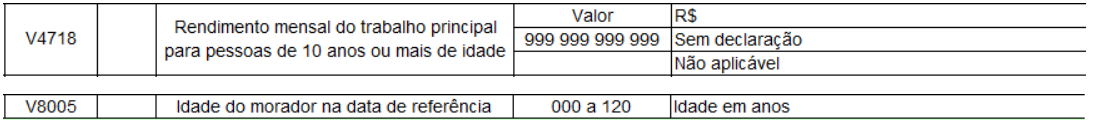

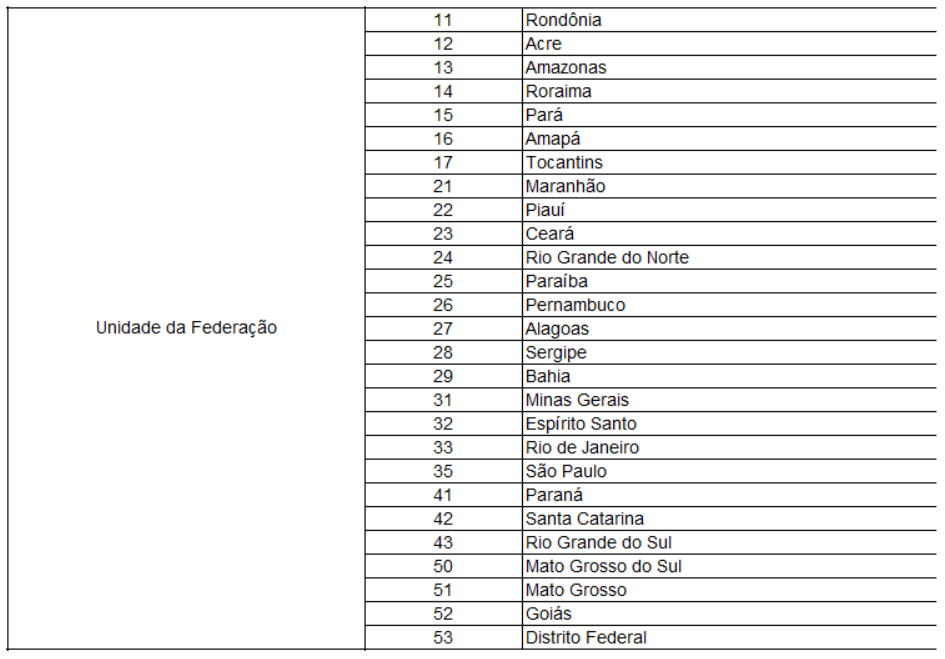

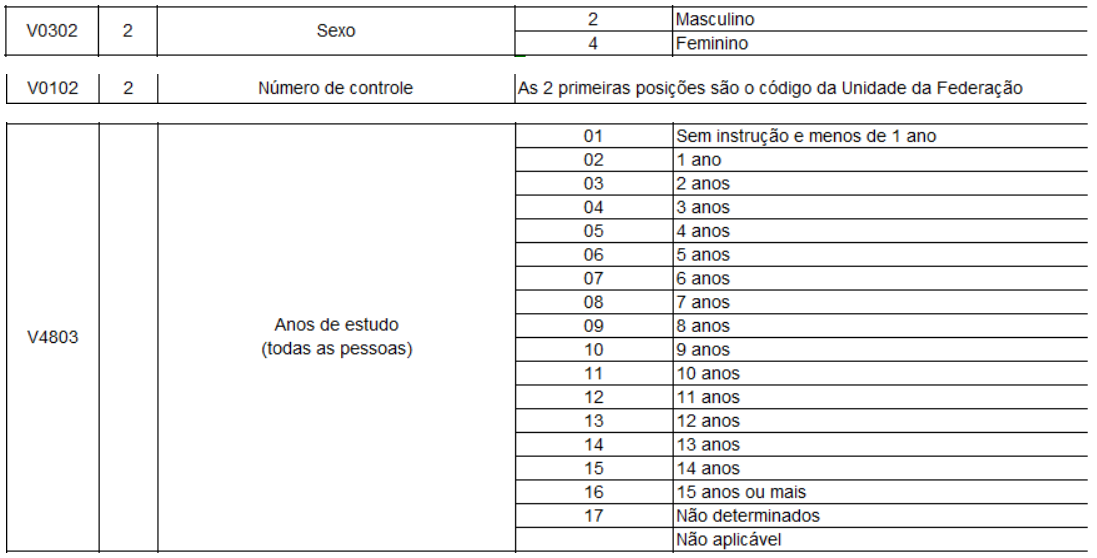

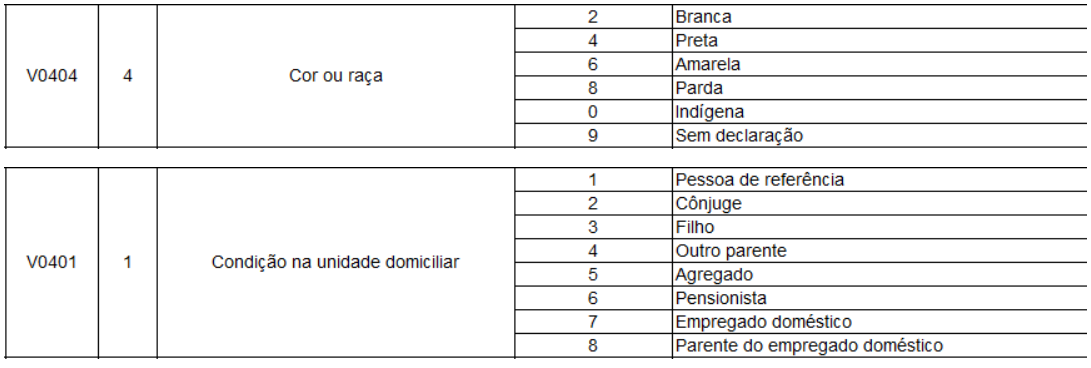

#### Transformando os arquivos dos microdados em uma planilha csv

https://medium.com/data-hackers/microdados-em-python-um-pacote-para-ler-dados-da-pnad-e-pof-e254cf18477d

In [2]:
#lerMicrodados.ler_PNAD('dados/Dados_20170517.zip', ano=2015, header=True)

#### Lendo a planilha

In [3]:
df = pd.read_csv('PES2015.csv')
df.head()

,V0101,V0102,V0103,V0301,V0302,V3031,V3032,V3033,V8005,V0401,...,V3628,V3629,V3630,V3631,V3632,V3633,V3634,V3637,V3638,V9993
0,2015,11000015,1,1,2,27,2,1992,23,1,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,333.0,634.0,20170511
1,2015,11000015,3,1,4,4,5,1992,23,1,...,2.0,NaN,2.0,NaN,1.0,NaN,2.0,333.0,470.0,20170511
2,2015,11000015,4,1,4,4,1,1980,35,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170511
3,2015,11000015,4,2,2,5,6,1981,34,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170511
4,2015,11000015,4,3,4,8,4,2004,11,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170511


### Selecionando as colunas da base de dados de acordo com o dicionário de variáveis

In [4]:
df = df[['V4718', 'V8005', 'V0102', 'V0302', 'V4803', 'V0404', 'V0401']]
df.head()

,V4718,V8005,V0102,V0302,V4803,V0404,V0401
0,800.0,23,11000015,2,12,8,1
1,1150.0,23,11000015,4,12,2,1
2,880.0,35,11000015,4,15,8,1
3,3000.0,34,11000015,2,15,8,2
4,NaN,11,11000015,4,4,8,3


### Criando a coluna UF
O código do estado do morador é os 2 primeiros dígitos de V0102, segundo o dicionário de variáveis.

In [5]:
df['UF'] = df['V0102'].apply(lambda x: str(x)[:2])
df.head()

,V4718,V8005,V0102,V0302,V4803,V0404,V0401,UF
0,800.0,23,11000015,2,12,8,1,11
1,1150.0,23,11000015,4,12,2,1,11
2,880.0,35,11000015,4,15,8,1,11
3,3000.0,34,11000015,2,15,8,2,11
4,NaN,11,11000015,4,4,8,3,11


### Renomeando as colunas e removendo a coluna V0102

In [6]:
df = df.rename(columns={'V4718': 'renda', 'V8005': 'idade', 'V0302': 'sexo','V4803': 'anos_estudo', 'V0404': 'cor', 'V0401': 'condicao'})
df = df.drop(columns=['V0102'])
df.head()

,renda,idade,sexo,anos_estudo,cor,condicao,UF
0,800.0,23,2,12,8,1,11
1,1150.0,23,4,12,2,1,11
2,880.0,35,4,15,8,1,11
3,3000.0,34,2,15,8,2,11
4,NaN,11,4,4,8,3,11


### Alguns tratamentos nos dados

Dadas algumas considerações sobre a variável *renda* no dicionário de variáveis, farei alguns tratamentos:
*   Eliminar os registros onde *renda* é inválida (999 999 999 999);
*   Eliminar os registros onde *renda* é missing;

Como vou usar apenas registros de pessoas de referência do domícilio, preciso filtrar o dataframe onde a coluna *condicao* é 1.

#### Renda inválida

In [7]:
df.renda.describe()

count    1.651930e+05
mean     1.299692e+10
std      1.132611e+11
min      0.000000e+00
25%      7.880000e+02
50%      1.000000e+03
75%      1.820000e+03
max      1.000000e+12
Name: renda, dtype: float64

In [8]:
df.query("renda == 999999999999")

,renda,idade,sexo,anos_estudo,cor,condicao,UF
91,1.000000e+12,36,2,12,8,1,11
498,1.000000e+12,60,4,12,2,2,11
639,1.000000e+12,24,2,12,2,3,11
961,1.000000e+12,26,4,7,8,2,11
1398,1.000000e+12,50,2,12,8,1,11
...,...,...,...,...,...,...,...
354450,1.000000e+12,45,2,12,2,2,53
354670,1.000000e+12,40,4,16,2,1,53
354671,1.000000e+12,42,2,16,2,2,53
356389,1.000000e+12,50,2,9,8,2,53


In [9]:
df = df.query("renda != 999999999999")
df.head()

,renda,idade,sexo,anos_estudo,cor,condicao,UF
0,800.0,23,2,12,8,1,11
1,1150.0,23,4,12,2,1,11
2,880.0,35,4,15,8,1,11
3,3000.0,34,2,15,8,2,11
4,NaN,11,4,4,8,3,11


In [10]:
df.renda.describe()

count    163046.000000
mean       1669.065380
std        2709.651405
min           0.000000
25%         788.000000
50%        1000.000000
75%        1800.000000
max      200000.000000
Name: renda, dtype: float64

#### Renda missing

In [11]:
df.renda.isna().sum()

191711

In [12]:
df[df.renda.isna()]

,renda,idade,sexo,anos_estudo,cor,condicao,UF
4,NaN,11,4,4,8,3,11
5,NaN,7,4,2,8,3,11
6,NaN,4,4,1,8,3,11
9,NaN,81,4,3,8,4,11
10,NaN,71,4,6,2,1,11
...,...,...,...,...,...,...,...
356894,NaN,57,4,1,8,1,53
356898,NaN,33,4,14,8,3,53
356900,NaN,39,4,7,8,2,53
356902,NaN,15,4,9,8,3,53


In [13]:
df = df.dropna(subset=['renda'])
df.head()

,renda,idade,sexo,anos_estudo,cor,condicao,UF
0,800.0,23,2,12,8,1,11
1,1150.0,23,4,12,2,1,11
2,880.0,35,4,15,8,1,11
3,3000.0,34,2,15,8,2,11
7,880.0,18,4,12,8,5,11


In [14]:
df.renda.isna().sum()

0

In [15]:
df.renda.describe()

count    163046.000000
mean       1669.065380
std        2709.651405
min           0.000000
25%         788.000000
50%        1000.000000
75%        1800.000000
max      200000.000000
Name: renda, dtype: float64

#### Considerando apenas pessoas de referência no domicílio

In [16]:
df.condicao.value_counts(normalize=True)

1    0.471278
2    0.259319
3    0.204991
4    0.055849
5    0.005876
6    0.001717
7    0.000932
8    0.000037
Name: condicao, dtype: float64

In [17]:
df = df.query("condicao == 1")
df.head()

,renda,idade,sexo,anos_estudo,cor,condicao,UF
0,800.0,23,2,12,8,1,11
1,1150.0,23,4,12,2,1,11
2,880.0,35,4,15,8,1,11
8,3500.0,46,2,6,2,1,11
11,150.0,47,4,9,8,1,11


In [18]:
df.condicao.value_counts(normalize=True)

1    1.0
Name: condicao, dtype: float64

#### Removendo a coluna *condicao*

In [19]:
df = df.drop(columns=['condicao'])
df.head()

,renda,idade,sexo,anos_estudo,cor,UF
0,800.0,23,2,12,8,11
1,1150.0,23,4,12,2,11
2,880.0,35,4,15,8,11
8,3500.0,46,2,6,2,11
11,150.0,47,4,9,8,11


In [20]:
df = df.reset_index(drop=True)
df.head()

,renda,idade,sexo,anos_estudo,cor,UF
0,800.0,23,2,12,8,11
1,1150.0,23,4,12,2,11
2,880.0,35,4,15,8,11
3,3500.0,46,2,6,2,11
4,150.0,47,4,9,8,11


## Distribuições de probabilidade

### Distribuição binomial

Um evento **binomial** é caracterizado pela possibilidade de ocorrência de apenas duas categorias. Estas categorias somadas representam todo o espaço amostral (todas as possibilidades do experimento), sendo também mutuamente excludentes, ou seja, a ocorrência de uma implica na não ocorrência da outra.

Em análises estatísticas o uso mais comum da distribuição binomial é na solução de problemas que envolvem situações de **sucesso** e **fracasso**.

# $$P(k)=\binom{n}{k} p^k q^{n-k}$$

Onde:

$p$ = probabilidade de sucesso

$q = (1 - p)$ = probabilidade de fracasso

$n$ = número de eventos estudados

$k$ = número de eventos desejados que tenham sucesso

#### Experimento Binomial

1. Realização de $n$ ensaios idênticos.

2. Os ensaios são independentes.

3. Somente dois resultados são possíveis, exemplo: Verdadeiro ou falso; Cara ou coroa; Sucesso ou fracasso.

4. A probabilidade de sucesso é representada por $p$ e a de fracasso por $1-p=q$. Estas probabilidades não se modificam de ensaio para ensaio.

#### Média da distribuição binomial

O valor esperado ou a média da distribuição binomial é igual ao número de experimentos realizados multiplicado pela chance de ocorrência do evento.

# $$\mu = n \times p$$

#### Desvio padrão da distribuição binomial

O desvio padrão é o produto entre o número de experimentos, a probabilidade de sucesso e a probabilidade de fracasso.

# $$\sigma = \sqrt{n \times p \times q}$$

#### Combinações

Número de combinações de $n$ objetos, tomados $k$ a cada vez, é:

# $$C_{k}^{n} = \binom{n}{k} = \frac{n!}{k!(n - k)!}$$

Onde

## $$n! = n\times(n-1)\times(n-2)\times...\times(2)\times(1)$$
## $$k! = k\times(k-1)\times(k-2)\times...\times(2)\times(1)$$

Por definição

## $$0! = 1$$

https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.comb.html

#### <font color=blue>Exemplo: Mega sena</font>

Em um volante de loteria da Mega Sena temos um total de **60 números** para escolher onde a aposta mínima é de **seis números**. Você que é curiosa(o) resolve calcular a probabilidade de se acertar na Mega Sena com apenas **um jogo**. Para isso precisamos saber quantas **combinações de seis números podem ser formadas com os 60 números disponíveis**.

### $$C_{6}^{60} = \binom{60}{6} = \frac{60!}{6!(60 - 6)!}$$

Fazendo no python

In [21]:
comb_mega_sena = comb(60, 6)
print(f"Número de combinações diferentes: {comb_mega_sena}")

Número de combinações diferentes: 50063860.0


In [22]:
prob_mega_sena = 1/comb_mega_sena
print('Probabilidade de acertar a mega sena usando apenas 1 bilhete: %0.15f' %prob_mega_sena)

Probabilidade de acertar a mega sena usando apenas 1 bilhete: 0.000000019974489


#### <font color='red'>Problema</font>

Em um concurso para preencher uma vaga de cientista de dados temos um total de **10 questões** de múltipla escolha com **3 alternativas possíveis** em cada questão. **Cada questão tem o mesmo valor.** Suponha que um candidato resolva se aventurar sem ter estudado absolutamente nada. Ele resolve fazer a prova de olhos vendados e chutar todas as resposta. Assumindo que a prova **vale 10 pontos e a nota de corte seja 5**, obtenha a probabilidade deste candidato **acertar 5 questões** e também a probabilidade deste candidato **passar para a próxima etapa do processo seletivo**.

Aparentemente, essas duas questões são a mesma coisa. Porém, não são. Queremos a probabilidade do candidato acertar 5 questões e a probabilidade dele passar pro próximo passo do processo seletivo, que pode significar que ele acertou 5, 6, 7, 8, 9 ou 10 questões.

#### <font color='green'>Qual o número de ensaios ($n$)?</font>

In [23]:
n = 10 #pois, possuimos 10 questões
n

10

#### <font color='green'>Os ensaios são independentes?</font>

Sim. A opção escolhida em uma questão não influencia em nada a opção escolhida em outra questão. Além disso, o candidato está chutando todas as questões, o que nos mostra que realmente não há influência de uma questão na outra.

#### <font color='green'>Somente dois resultados são possíveis em cada ensaio?</font>

Sim. O candidato tem duas possibilidades: **acertar** ou **errar** uma questão. (Mesmo cada questão possuindo 3 alternativas cada).

#### <font color='green'>Qual a probabilidade de sucesso ($p$)?</font>

In [24]:
numero_de_alternativas_por_questao = 3
p = 1/numero_de_alternativas_por_questao
p

0.3333333333333333

#### <font color='green'>Qual a probabilidade de fracasso ($q$)?</font>

In [25]:
q = 1 - p
q

0.6666666666666667

#### <font color='red'>Solução problema 1</font>

Probabilidade do candidato acertar 5 questões.

#### <font color='green'>Qual o total de eventos que se deseja obter sucesso ($k$)?</font>

In [26]:
k = 5
k

5

#### <font color='green'>Solução "manual"</font>

In [27]:
probabilidade = (comb(n, k) * (p ** k) * (q ** (n - k)))
print('%0.8f' % probabilidade)

0.13656455


#### <font color='green'>Solução com python</font>

In [28]:
probabilidade_python = binom.pmf(k, n, p)
print('%0.8f' % probabilidade_python)

0.13656455


#### <font color='red'>Solução problema 2</font>

Probabilidade do candidato passar para a próxima etapa do processo seletivo. Ou seja, probabilidade do candidato acertar, no mínimo, 5 questões.

### $$P(acertar \geq 5) = P(5) + P(6) + P(7) + P(8) + P(9) + P(10)$$

#### <font color='green'>Solução com python 1</font>

In [29]:
binom.pmf(5, n, p) + binom.pmf(6, n, p) + binom.pmf(7, n, p) + binom.pmf(8, n, p) + binom.pmf(9, n, p) + binom.pmf(10, n, p)

0.21312808006909492

#### <font color='green'>Solução com python 2</font>

In [30]:
binom.pmf([5, 6, 7, 8, 9, 10], n, p).sum()

0.21312808006909492

#### <font color='green'>Solução com python 3</font>

Usando a binom com função comulativa *cdf*

In [31]:
binom.cdf(4, n, p) # prob de acertar 0 + prob de 1 + prob de 2 + prob de 3 + prob de 4 

0.7868719199309048

In [32]:
#Portanto,

1 - binom.cdf(4, n, p)

0.21312808006909523

#### <font color='green'>Solução com python 4</font>

Usando a função *sf* que faz o mesmo que fizemos na solução 3

In [33]:
binom.sf(4, n, p)

0.21312808006909525

#### <font color='red'>Problema extra 1</font>

Uma moeda, **perfeitamente equilibrada**, é lançada para o alto **quatro vezes**. Utilizando a distribuição binomial, obtenha a probabilidade de a moeda cair com a face **coroa** voltada para cima **duas vezes**.

Lembrando que a expressão **perfeitamente equilibrada** indica que a moeda usada é honesta, ou seja, apresenta a mesma probabilidade de se obter **cara** ou **coroa**.

Aqui,

$n$ = 4 -> total de lançamentos

$k$ = 2 -> total de sucessos

$p$ = 1/2 -> probabilidade de obter coroa no lançamento

In [34]:
binom.pmf(2, 4, 1/2)

0.375

#### <font color='red'>Problema extra 2</font>

Um dado, **perfeitamente equilibrado**, é lançado para o alto **dez vezes**. Utilizando a distribuição binomial, obtenha a probabilidade de o dado cair com o número **cinco** voltado para cima **pelo menos três vezes**.

Aqui, queremos a probabilidade do cinco aparecer pelo menos 3 vezes, ou seja, jogando dez vezes, qual a probabilidadade dele aparecer no mínimo 3 vezes.

Aqui,

$n$ = 10 -> total de lançamentos

$k$ = no mínimo 3 -> total de sucessos

$p$ = 1/6

In [35]:
binom.pmf(3, 10, 1/6) + binom.pmf(4, 10, 1/6) + binom.pmf(5, 10, 1/6) + binom.pmf(6, 10, 1/6) + binom.pmf(7, 10, 1/6) + binom.pmf(8, 10, 1/6) + binom.pmf(9, 10, 1/6) + binom.pmf(10, 10, 1/6)

0.22477320212874055

In [36]:
binom.sf(2, 10, 1/6)

0.22477320212874055

#### Aplicação da média

#### <font color='blue'>Exemplo: Gincana</font> 

Uma cidade do interior realiza todos os anos uma gincana para arrecadar fundos para o hospital da cidade. Na última gincana se sabe que a **proporção de participantes do sexo feminino foi de 60%**. **O total de equipes, com 12 integrantes, inscritas na gincana deste ano é de 30**. Com as informações acima responda: Quantas equipes deverão ser formadas por **8 mulheres**?

Ou seja, dessas 30 equipes, quantas, em média, deverão ser formadas por 8 mulheres? (Binomial -> ou é formada por 8 mulheres + 4 homens, ou não)

#### <font color='green'>Qual o valor de $p$?</font>

Probabilidade de eu selecionar uma mulher

In [37]:
p = 0.6
p

0.6

#### <font color='green'>Qual o valor de $n$?</font>

Quantidade de vezes que preciso selecionar alguém para uma equipe.

In [38]:
n = 12
n

12

#### <font color='green'>Qual o valor de $k$?</font>

Quantas mulheres quero selecionar em uma equipe

In [39]:
k = 8
k

8

In [40]:
prob_gincana = binom.pmf(k, n, p)
print('Probabilidade de uma equipe ser selecionada com 8 mulheres: %0.8f' %prob_gincana)

Probabilidade de uma equipe ser selecionada com 8 mulheres: 0.21284094


#### <font color='green'>Mas, em média, quantas equipes deverão ser formadas por 8 mulheres?</font>

$$\mu = n \times p$$

In [41]:
equipes_gincana = round(30 * prob_gincana, 0)
equipes_gincana

6.0

#### <font color='red'>Problema extra</font>

Suponha que a probabilidade de um casal ter filhos com olhos azuis seja de 22%. Em 50 famílias, com 3 crianças cada uma, quantas podemos esperar que tenham dois filhos com olhos azuis?

$n$ = 3

$k$ = 2

$p$ = 0.22

In [42]:
prob_olhos_azuis = binom.pmf(2, 3, 0.22)
prob_olhos_azuis

0.11325599999999993

In [43]:
familias_olhos_azuis = 50 * prob_olhos_azuis
familias_olhos_azuis

5.662799999999996

### Distribuição Poisson

É empregada para descrever o número de ocorrências em um intervalo de tempo ou espaço específico. Os eventos são caracterizados pela possibilidade de contagem dos sucessos, mas não a possibilidade de contagem dos fracassos.

Como exemplos de processos onde podemos aplicar a distribuição de Poisson temos a determinação do número de clientes que entram em uma loja em determinada hora, o número de carros que chegam em um drive-thru de uma lanchonete na hora do almoço, a determinação do número de acidentes registrados em um trecho de estrada etc.

# $$P(k) = \frac{e^{-\mu}(\mu)^k}{k!}$$

Onde:

$e$ = constante cujo valor aproximado é 2,718281828459045

$\mu$ = representa o número médio de ocorrências em um determinado intervalo de tempo ou espaço

$k$ = número de sucessos no intervalo desejado

#### Experimento Poisson

1. A probabilidade de uma ocorrência é a mesma em todo o intervalo observado.

2. O número de ocorrências em determinado intervalo é independente do número de ocorrências em outros intervalos.

3. A probabilidade de uma ocorrência é a mesma em intervalos de igual comprimento.

#### Média da distribuição Poisson

# $$\mu$$

#### Desvio padrão da distribuição Poisson

# $$\sigma = \sqrt{\mu}$$

#### <font color='red'>Problema</font>

Um restaurante recebe em média **20 pedidos por hora**. Qual a chance de que, em determinada hora escolhida ao acaso, o restaurante receba **15 pedidos**?

#### <font color='green'>Qual o número médio de ocorrências por hora $\mu$?</font>

In [44]:
media = 20
media

20

#### <font color='green'>Qual o número de ocorrências que queremos obter no período $k$?</font>

In [45]:
k = 15
k

15

#### <font color='green'>Solução manual</font>

In [46]:
prob_restaurante = ((np.e ** (-media)) * (media ** k)) / (np.math.factorial(k))
print('%0.8f' %prob_restaurante)

0.05164885


#### <font color='green'>Solução com python</font>

In [47]:
prob_restaurante_python = poisson.pmf(k, media)
print('%0.8f' %prob_restaurante_python)

0.05164885


#### <font color='red'>Problema extra</font>

O número médio de clientes que entram em uma padaria por hora é igual a 20. Obtenha a probabilidade de, na próxima hora, entrarem exatamente 25 clientes.

Aqui,

$\mu$ = 20

$k$ = 25

In [48]:
prob_padaria = poisson.pmf(25, 20)
print('%0.8f' %prob_padaria)

0.04458765


### Distribuição normal

A distribuição normal é uma das mais utilizadas em estatística. É uma distribuição contínua, onde a distribuição de frequências de uma variável quantitativa apresenta a forma de sino e é simétrica em relação a sua média.

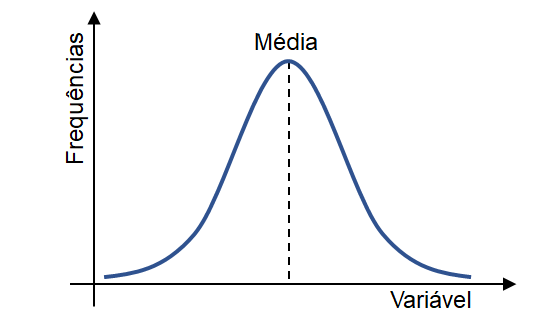

#### Características importantes

1. É simétrica em torno da média;

2. A área sob a curva corresponde à proporção 1 ou 100%;

3. As medidas de tendência central (média, mediana e moda) apresentam o mesmo valor;

4. Os extremos da curva tendem ao infinito em ambas as direções e, teoricamente, jamais tocam o eixo $x$;

5. O desvio padrão define o achatamento e largura da distribuição. Curvas mais largas e mais achatadas apresentam valores maiores de desvio padrão;

6. A distribuição é definida por sua média e desvio padrão;

7. A probabilidade sempre será igual à área sob a curva, delimitada pelos limites inferior e superior.

Densidade de probabilidade:

# $$f(x) = \frac{1}{\sqrt{2\pi\sigma}}e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$$

Onde:

$x$ = variável normal

$\sigma$ = desvio padrão

$\mu$ = média

A probabilidade é obtida a partir da área sob a curva, delimitada pelos limites inferior e superior especificados. Um exemplo pode ser visto na figura abaixo.

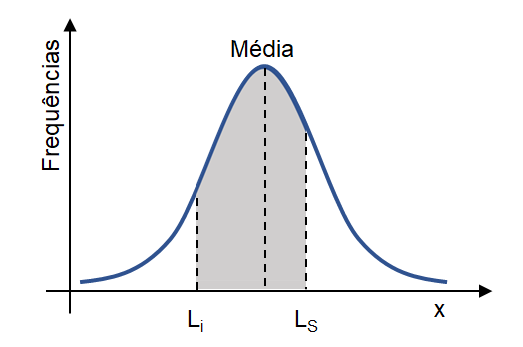

Para obter a área acima basta calcular a integral da função para os intervalos determinados. Conforme equação abaixo:

# $$P(L_i<x<L_s) = \int_{L_i}^{L_s}\frac{1}{\sqrt{2\pi\sigma}}e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$$

Onde:

$x$ = variável normal

$\sigma$ = desvio padrão

$\mu$ = média

$L_i$ = limite inferior

$L_s$ = limite superior

#### Tabelas padronizadas

As tabelas padronizadas foram criadas para facilitar a obtenção dos valores das áreas sob a curva normal e eliminar a necessidade de solucionar integrais definidas.

Para consultarmos os valores em uma tabela padronizada basta transformarmos nossa variável em uma variável padronizada $Z$.

Esta variável $Z$ representa o afastamento em desvios padrões de um valor da variável original em relação à média.

# $$Z = \frac{x-\mu}{\sigma}$$

Onde:

$x$ = variável normal com média $\mu$ e desvio padrão $\sigma$

$\sigma$ = desvio padrão

$\mu$ = média

#### Construindo tabela normal padronizada
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

In [49]:
tabela_normal_padronizada = pd.DataFrame(
    [], 
    index=["{0:0.2f}".format(i / 100) for i in range(0, 400, 10)],
    columns = ["{0:0.2f}".format(i / 100) for i in range(0, 10)]
)

for index in tabela_normal_padronizada.index:
    for column in tabela_normal_padronizada.columns:
        Z = np.round(float(index) + float(column), 2)
        tabela_normal_padronizada.loc[index, column] = "{0:0.4f}".format(norm.cdf(Z))

tabela_normal_padronizada.rename_axis('Z', axis = 'columns', inplace = True)

tabela_normal_padronizada

Z,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09
0.00,0.5000,0.5040,0.5080,0.5120,0.5160,0.5199,0.5239,0.5279,0.5319,0.5359
0.10,0.5398,0.5438,0.5478,0.5517,0.5557,0.5596,0.5636,0.5675,0.5714,0.5753
0.20,0.5793,0.5832,0.5871,0.5910,0.5948,0.5987,0.6026,0.6064,0.6103,0.6141
0.30,0.6179,0.6217,0.6255,0.6293,0.6331,0.6368,0.6406,0.6443,0.6480,0.6517
0.40,0.6554,0.6591,0.6628,0.6664,0.6700,0.6736,0.6772,0.6808,0.6844,0.6879
0.50,0.6915,0.6950,0.6985,0.7019,0.7054,0.7088,0.7123,0.7157,0.7190,0.7224
0.60,0.7257,0.7291,0.7324,0.7357,0.7389,0.7422,0.7454,0.7486,0.7517,0.7549
0.70,0.7580,0.7611,0.7642,0.7673,0.7704,0.7734,0.7764,0.7794,0.7823,0.7852
0.80,0.7881,0.7910,0.7939,0.7967,0.7995,0.8023,0.8051,0.8078,0.8106,0.8133
0.90,0.8159,0.8186,0.8212,0.8238,0.8264,0.8289,0.8315,0.8340,0.8365,0.8389


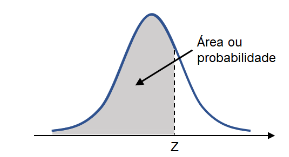

A tabela acima fornece a área sob a curva entre $-\infty$ e $Z$ desvios padrão acima da média. Lembrando que por se tratar de valores padronizados temos $\mu = 0$.

#### <font color='red'>Problema extra</font>

Em um estudo sobre as alturas dos moradores de uma cidade verificou-se que o conjunto de dados segue uma **distribuição aproximadamente normal**, com **média 1,70** e **desvio padrão de 0,1**. Com estas informações obtenha o seguinte conjunto de probabilidades:

> **A.** probabilidade de uma pessoa, selecionada ao acaso, ter menos de 1,80 metros.

> **B.** probabilidade de uma pessoa, selecionada ao acaso, ter entre 1,60 metros e 1,80 metros.    

> **C.** probabilidade de uma pessoa, selecionada ao acaso, ter mais de 1,90 metros.

#### <font color='orange'>Item A</font>

Identificação da área sob a curva

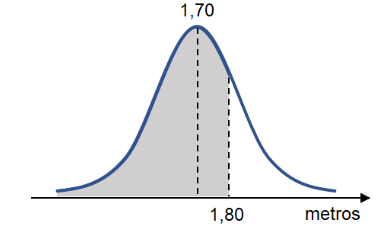

#### <font color='green'>Obtendo a variável padronizada $Z$</font>

In [50]:
media = 1.7
media

1.7

In [51]:
desvio_padrao = 0.1
desvio_padrao

0.1

In [52]:
z = (1.8 - media) / desvio_padrao
z

1.0000000000000009

#### <font color='green'>Solução utilizando a tabela</font>

Soma o valor da linha com o valor da coluna.

In [53]:
prob_altura = 0.8413
prob_altura

0.8413

#### <font color='green'>Solução utilizando python</font>

Utiliza o cdf do stats norm.

In [54]:
prob_altura_python = norm.cdf(z)
prob_altura_python

0.8413447460685431

#### <font color='orange'>Item B</font>

Identificação da área sob a curva.

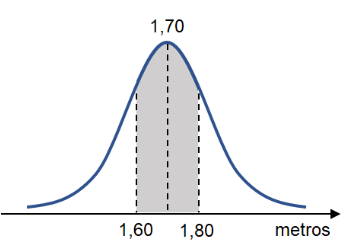

Como a distribuição normal é simétrica em torno da média, concluímos que a área sob a curva entre 1.7 e 1.6 e entre 1.7 e 1.8 é igual, por conta dessa simetria.

Portanto, descobrindo a área de uma dessas áreas e multiplicando por dois, já conseguimos nosso resultado.

Observe que, se calcularmos a área de menos infinito até 1.8 e subtrair a área de menos infinito até 1.7 (média) (que é a metade da distribuição), obteremos a área que queremos de 1.7 até 1.8. (Solução 1)

Outra forma é, observe que a área de menos infinito até 1.6 é a mesma que a área de 1.8 até mais infinito. Além disso, note que queremos a área que vai de 1.8 até -infinito menos a área de 1.6 até -infinito. Ou seja, 1.6 até -infinito é igual a 1 menos 1.8 até -infinito, onde o 1 corresponde a distribuição total. Logo, podemos obter a área de 1.6 até 1.8 obtendo a área de 1.8 até -infinito menos a área de 1 menos 1.8 até -infinito. (Solução 2)

#### <font color='green'>Obtendo a variável padronizada $Z$</font>

Padronizando 1.8

In [55]:
z_1_8 = round(((1.8 - media) / desvio_padrao), 2)
z_1_8

1.0

Padronizando a média

In [56]:
z_1_7 = (1.7 - media) / desvio_padrao
z_1_7

0.0

Padronizando 1.6

In [57]:
z_1_6 = round(((1.6 - media) / desvio_padrao), 2)
z_1_6

-1.0

#### <font color='green'>Solução usando a tabela</font>

Usando a solução 1

In [58]:
prob = (0.8413 - 0.5) * 2
prob

0.6826000000000001

Usando a solução 2

In [59]:
prob2 = 0.8413 - (1 - 0.8413)
prob2

0.6826000000000001

#### <font color='green'>Solução usando o python</font>

Usando a solução 1

In [60]:
prob_python = (norm.cdf(z_1_8) - norm.cdf(z_1_7))  * 2
prob_python

0.6826894921370859

Usando a solução 2

In [61]:
prob_python2 = norm.cdf(z_1_8) - (1 - norm.cdf(z_1_8))
prob_python2

0.6826894921370859

Outra forma mais simples usando o python

In [62]:
# A solução 2 e essa são equivalentes, pois norm.cdf(z_1_6) = (1 - norm.cdf(z_1_8))

prob_python3 = norm.cdf(z_1_8) - norm.cdf(z_1_6)
prob_python3

0.6826894921370859

#### <font color='orange'>Item C</font>

Identificação da área sob a curva.

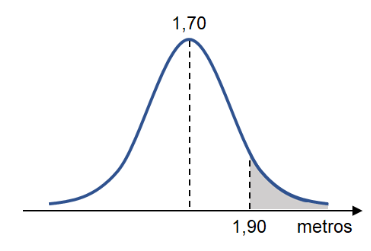


Pela tabela, temos a probabilidade de ser menor que 1.9, mas não queremos isso, queremos a probabilidade de ser maior.

Porém, a probabilidade de ser maior é igual a 1 menos a probabilidade de ser menor, onde 1 é a distribuição total.

#### <font color='green'>Obtendo a variável padronizada $Z$</font>

In [63]:
z_1_9 = (1.9 - media) / desvio_padrao
z_1_9

1.9999999999999996

#### <font color='green'>Solução usando a tabela</font>

In [64]:
prob_c = 1 - 0.9767
prob_c

0.023299999999999987

#### <font color='green'>Solução usando python</font>

Solução 1

In [65]:
prob_c_python = 1 - norm.cdf(z_1_9)
prob_c_python

0.02275013194817921

Solução 2

In [66]:
prob_c_python2 = norm.cdf(-z_1_9)
prob_c_python2

0.022750131948179216

#### <font color='red'>Problema extra</font>

A aplicação de uma prova de estatística em um concurso apresentou um conjunto de notas normalmente distribuídas. Verificou-se que o conjunto de notas tinha média 70 e desvio padrão de 5 pontos.

Qual a probabilidade de um aluno, selecionado ao acaso, ter nota menor que 85?

$\mu$ = 70

$\sigma$ = 5

$x$ = 85

Temos um problema similar ao item A.

Padronizando a variável:

In [67]:
z = (85 - 70)/5
z

3.0

Pela tabela

In [68]:
prob_prova = 0.9987
prob_prova

0.9987

Usando python

In [69]:
pro_prova_python = norm.cdf(z)
pro_prova_python

0.9986501019683699

#### <font color='red'>Problema extra</font>

O faturamento diário de um motorista de aplicativo segue uma distribuição aproximadamente normal, com média 300,00 e desvio padrão igual a 50,00. Obtenha as probabilidades de que, em um dia aleatório, o motorista ganhe:

1) Entre 250,00 e 350,00

2) Entre 400,00 e 500,00

In [70]:
media_extra2 = 300
desvio_padrao_extra2 = 50

#### <font color='orange'>1</font>

In [71]:
z_inf_1 = (250 - media_extra2) / desvio_padrao_extra2
z_inf_1

-1.0

In [72]:
z_sup_1 = (350 - media_extra2) / desvio_padrao_extra2
z_sup_1

1.0

In [73]:
prob_python_extra2_a = norm.cdf(z_sup_1) - norm.cdf(z_inf_1)
prob_python_extra2_a

0.6826894921370859

#### <font color='orange'>2</font>

Essa é a área de 500 até -infinito menos a área de 400 até -infinito

In [74]:
z_inf_2 = (400 - media_extra2) / desvio_padrao_extra2
z_inf_2

2.0

In [75]:
z_sup_2 = (500 - media_extra2) / desvio_padrao_extra2
z_sup_2

4.0

In [76]:
prob_python_extra2_b = norm.cdf(z_sup_2) - norm.cdf(z_inf_2)
prob_python_extra2_b

0.02271846070634609

#### <font color='red'>Problema extra</font>

O Inmetro verificou que as lâmpadas incandescentes da fabricante XPTO apresentam uma vida útil normalmente distribuída, com média igual a 720 dias e desvio padrão igual a 30 dias. Calcule a probabilidade de uma lâmpada, escolhida ao acaso, durar:

1) Entre 650 e 750 dias

2) Mais que 800 dias

3) Menos que 700 dias

In [77]:
media_extra3 = 720
desvio_padrao_extra3 = 30

#### <font color='orange'>1</font>

In [78]:
z_inf_3 = (650 - media_extra3) / desvio_padrao_extra3
z_inf_3

-2.3333333333333335

In [79]:
z_sup_3 = (750 - media_extra3) / desvio_padrao_extra3
z_sup_3

1.0

In [80]:
prob_python_extra3_a = norm.cdf(z_sup_3) - norm.cdf(z_inf_3)
prob_python_extra3_a

0.8315294174398976

#### <font color='orange'>2</font>

In [81]:
z_inf_4 = (800 - media_extra3) / desvio_padrao_extra3
z_inf_4

2.6666666666666665

Solução 1

In [82]:
prob_python_extra3_b_1 = 1 - norm.cdf(z_inf_4)
prob_python_extra3_b_1

0.003830380567589775

Solução 2

In [83]:
prob_python_extra3_b_2 = norm.cdf(-z_inf_4)
prob_python_extra3_b_2

0.0038303805675897365

#### <font color='orange'>3</font>

In [84]:
z_inf_5 = (700 - media_extra3) / desvio_padrao_extra3
z_inf_5

-0.6666666666666666

In [85]:
prob_python_extra_c = norm.cdf(z_inf_5)
prob_python_extra_c

0.2524925375469229

## Amostragem

### População

Conjunto de todos os elementos de interesse em um estudo. Diversos elementos podem compor uma população, por exemplo: pessoas, idades, alturas, carros etc.

Com relação ao tamanho, as populações podem ser limitadas (populações finitas) ou ilimitadas (populações infinitas).

### Populações finitas

Permitem a contagem de seus elementos. Como exemplos temos o número de funcionário de uma empresa, a quantidade de alunos em uma escola etc.

### Populações infinitas

Não é possível contar seus elementos. Como exemplos temos a quantidade de porções que se pode extrair da água do mar para uma análise, temperatura medida em cada ponto de um território etc.

<font color=red>Quando os elementos de uma população puderem ser contados, porém apresentando uma quantidade muito grande, assume-se a população como infinita.</font>

### Amostra

Subconjunto representativo da população.

Os atributos numéricos de uma população como sua média, variância e desvio padrão, são conhecidos como **parâmetros**. O principal foco da inferência estatística é justamente gerar estimativas e testar hipóteses sobre os parâmetros populacionais utilizando as informações de amostras.

### Quando utilizar uma amostra?

#### Populações infinitas

O estudo não chegaria nunca ao fim. Não é possível investigar todos os elementos da população.

#### Testes destrutivos

Estudos onde os elementos avaliados são totalmente consumidos ou destruídos. Exemplo: testes de vida útil, testes de segurança contra colisões em automóveis.

#### Resultados rápidos

Pesquisas que precisam de mais agilidade na divulgação. Exemplo: pesquisas de opinião, pesquisas que envolvam problemas de saúde pública.

#### Custos elevados

Quando a população é finita mas muito numerosa, o custo de um censo pode tornar o processo inviável.

### Amostragem aleatória simples

É uma das principais maneiras de se extrair uma amostra de uma população. A exigência fundamental deste tipo de abordagem é que cada elemeto da população tenha as mesmas chances de ser selecionado para fazer parte da amostra.

Sabemos que uma amostra tem que ser representativa, onde a chance de selecionarmos uma pessoa com determinada característica na população deve ser a mesma chance de termos esta pessoa com esta mesma característica na amostra.

Por exemplo, se temos uma população onde a proporção de homens é 40%, deveremos garantir um valor bem próximo a isso na amostra. Obviamente não será idêntica, afinal há sempre uma margem de erro embutida quando fazemos uma seleção de amostra. O tipo de erro pode ser calulado quando estivermos falando de cálculo de tamanho de amostra.

#### Obtendo a quantidade de registros do nosso dataframe

In [86]:
df.shape[0]

76840

#### Obtendo a média da renda desse conjunto de dados

Nosso conjunto de dados representa os registros da nossa população.

In [87]:
df.renda.mean()

2000.3831988547631

Quando selecionamos uma amostra, a utilizamos para fazermos inferências sobre esses parâmetros populacionais. Caso seja representativa com erro controlado, chegaremos a um valor próximo aos 2 mil que retornamos.

#### Obtendo uma amostra do dataframe

Sem nenhum critério, usaremos 100 como tamanho da amostra.

In [88]:
amostra = df.sample(n = 100, random_state = 101)
amostra

,renda,idade,sexo,anos_estudo,cor,UF
29042,480.0,39,2,5,8,29
62672,250.0,55,2,6,2,43
29973,788.0,36,4,12,2,29
22428,1680.0,46,2,8,8,26
55145,2500.0,37,2,9,2,41
...,...,...,...,...,...,...
40245,2800.0,35,2,12,2,32
30997,1924.0,34,4,14,4,29
15094,130.0,60,2,1,4,23
48788,460.0,39,4,7,2,35


#### Obtendo a quantidade de registros da amostra

Deve ser igual a 100.

In [89]:
amostra.shape[0]

100

#### Obtendo a média da renda da amostra

In [90]:
amostra.renda.mean()

2150.85

Um pouco diferente dos 2000 da população, mas não tão longe assim.

Lembrando que, nesse exemplo, não foi utilizado nenhum critério para selecionar o $n$ e devemos garantir que a amostra seja de fato representativa da população.

#### Fazendo esse teste com a variável sexo

Obtendo a proporção de genêro na população

In [91]:
df.sexo.value_counts(normalize=True)

2    0.692998
4    0.307002
Name: sexo, dtype: float64

Obtendo a proporção de genêro na amostra

In [92]:
amostra.sexo.value_counts(normalize=True)

2    0.69
4    0.31
Name: sexo, dtype: float64

Observe que, mesmo sendo uma amostra tão pequena, ela está apresentando uma proporção parecida com a da população.

Como não foi usada nenhuma técnica para definir $n$, não há como ter certeza de que esse resultado próximo garante que seja uma amostra representativa o suficiente. Existem técnicas de seleção de tamanho de amostra onde lidamos com uma margem de erro para controlar e calcular, gerando uma confiança de que o valor vai estar dentro de um intervalo.

### Amostragem estratificada

É uma melhoria do processo de amostragem aleatória simples. Neste método é proposta a divisão da população em subgrupos de elementos com características similares, ou seja, grupos mais homogêneos. Com estes subgrupos separados, aplica-se a técnica de amostragem aleatória simples dentro de cada subgrupo individualmente.

### Amostragem por conglomerados

Também visa melhorar o critério de amostragem aleatória simples. Na amostragem por conglomerados são também criados subgrupos, porém não serão homogêneos como na amostragem estratificada. Na amostragem por conglomerados os subgrupos serão heterogêneos, onde, em seguida, serão aplicadas a amostragem aleatória simples ou estratificada.

Um exemplo bastante comum de aplicação deste tipo de técnica é na divisão da população em grupos territoriais, onde os elementos investigados terão características bastante variadas.

## Estimação

#### <font color='red'>Problema</font>

Suponha que os pesos dos sacos de arroz de uma indústria alimentícia se distribuem aproximadamente como uma normal de **desvio padrão populacional igual a 150 g**. Selecionada uma **amostra aleatório de 20 sacos** de um lote específico, obteve-se um **peso médio de 5.050 g**. Construa um **intervalo de confiança para a média populacional** assumindo um **nível de significância de 5%**.

---

É a forma de se fazer suposições generalizadas sobre os parâmetros de uma população tendo como base as informações de uma amostra.

- **Parâmetros** são os atributos numéricos de uma população, tal como a média, desvio padrão etc.

- **Estimativa** é o valor obtido para determinado parâmetro a partir dos dados de uma amostra da população.

### Teorema do limite central

> O **Teorema do Limite Central** afirma que, com o aumento do tamanho da amostra, a distribuição das médias amostrais se aproxima de uma distribuição normal com média igual à média da população e desvio padrão igual ao desvio padrão da variável original dividido pela raiz quadrada do tamanho da amostra. Este fato é assegurado para $n$ maior ou igual a 30.

# $$\sigma_\bar{x} = \frac{\sigma}{\sqrt{n}}$$

O desvio padrão das médias amostrais é conhecido como **erro padrão da média**

#### <font color='green'>Entendendo o teorema do limite central

Criando 1500 amostras com 2000 registros cada da coluna idade do dataframe df.

In [93]:
n = 2000
total_de_amostras = 1500

In [94]:
amostras = pd.DataFrame()
amostras

""


In [95]:
for i in range(total_de_amostras):
    _ = df.idade.sample(n)
    _.index = range(0, len(_))
    amostras[f'amostra_{i}'] = _
    
amostras.head()

,amostra_0,amostra_1,amostra_2,amostra_3,amostra_4,amostra_5,amostra_6,amostra_7,amostra_8,amostra_9,...,amostra_1490,amostra_1491,amostra_1492,amostra_1493,amostra_1494,amostra_1495,amostra_1496,amostra_1497,amostra_1498,amostra_1499
0,48,48,40,32,36,44,40,26,36,28,...,42,23,52,30,36,55,23,40,38,47
1,36,34,55,48,32,52,21,38,47,40,...,53,56,47,75,41,29,44,46,48,60
2,25,41,55,41,50,53,35,59,46,71,...,43,40,29,44,34,53,40,36,52,40
3,34,34,54,50,24,74,46,36,44,34,...,52,30,45,31,39,24,49,48,37,78
4,45,70,49,49,43,23,30,53,37,30,...,24,35,40,47,48,35,51,47,35,50


In [96]:
amostras.mean()

amostra_0       43.6600
amostra_1       44.4500
amostra_2       44.3210
amostra_3       44.2550
amostra_4       44.1175
                 ...   
amostra_1495    44.3100
amostra_1496    43.4365
amostra_1497    44.1815
amostra_1498    43.7220
amostra_1499    43.9395
Length: 1500, dtype: float64

> O Teorema do Limite Central afirma que, **com o aumento do tamanho da amostra, a distribuição das médias amostrais se aproxima de uma distribuição normal** com média igual à média da população e desvio padrão igual ao desvio padrão da variável original dividido pela raiz quadrada do tamanho da amostra. Este fato é assegurado para n maior ou igual a 30.

Vejamos isso.

<AxesSubplot:>

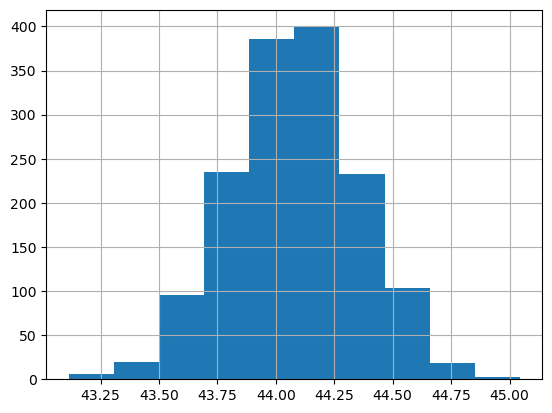

In [97]:
amostras.mean().hist()

De fato, se assemelha a uma distribuição normal.

> O Teorema do Limite Central afirma que, com o aumento do tamanho da amostra, a distribuição das médias amostrais se aproxima de uma distribuição normal **com média igual à média da população** e desvio padrão igual ao desvio padrão da variável original dividido pela raiz quadrada do tamanho da amostra. Este fato é assegurado para n maior ou igual a 30.

Vejamos isso.

In [98]:
print(f"Média de idade da população: {df.idade.mean()}")

Média de idade da população: 44.07142113482561


In [99]:
print(f"Média das médias amostrais: {amostras.mean().mean()}")

Média das médias amostrais: 44.07802033333334


De fato, as médias são bem próximas.

> O Teorema do Limite Central afirma que, com o aumento do tamanho da amostra, a distribuição das médias amostrais se aproxima de uma distribuição normal com média igual à média da população e **desvio padrão igual ao desvio padrão da variável original dividido pela raiz quadrada do tamanho da amostra**. Este fato é assegurado para n maior ou igual a 30.

# $$\sigma_\bar{x} = \frac{\sigma}{\sqrt{n}}$$

Vejamos isso.

In [100]:
print(f"Desvio padrão das médias amostrais: {amostras.mean().std()}")

Desvio padrão das médias amostrais: 0.27454392605090194


In [101]:
print(f"Desvio padrão da variável original dividido pela raiz quadrada do tamanho da amostra: {df.idade.std() / np.sqrt(n)}")

Desvio padrão da variável original dividido pela raiz quadrada do tamanho da amostra: 0.2790743302740527


De fato, são bem próximos.

OBS.: Esse desvio padrão, conforme aumentamos a amostra, ele vai diminuindo, porque a média das médias amostrais vai se aproximando cada vez mais da média populacional.

### Níveis de confiança e significância

O **nível de confiança** ($1 - \alpha$) representa a probabilidade de acerto da estimativa. De forma complementar o **nível de significância** ($\alpha$) expressa a probabilidade de erro da estimativa.

O **nível de confiança** representa o grau de confiabilidade do resultado da estimativa estar dentro de determinado intervalo. Quando fixamos em uma pesquisa um **nível de confiança** de 95%, por exemplo, estamos assumindo que existe uma probabilidade de 95% dos resultados da pesquisa representarem bem a realidade, ou seja, estarem corretos.

O **nível de confiança** de uma estimativa pode ser obtido a partir da área sob a curva normal como ilustrado na figura abaixo.

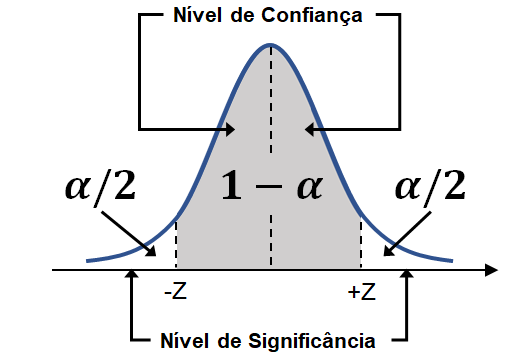

### Erro inferencial

O **erro inferencial** é definido pelo **desvio padrão das médias amostrais** $\sigma_\bar{x}$ e pelo **nível de confiança** determinado para o processo.

# $$e = z \frac{\sigma}{\sqrt{n}}$$

### Intervalos de confiança

#### <font color='green'>Intervalos de confiança para a média da população</font>

#### Com desvio padrão populacional conhecido

## $$\mu = \bar{x} \pm z\frac{\sigma}{\sqrt{n}}$$

#### Com desvio padrão populacional desconhecido

## $$\mu = \bar{x} \pm z\frac{s}{\sqrt{n}}$$

Quando calculamos intervalo de confiança com o nível de confiança de 95%, por exemplo, queremos dizer que o parâmetro estimado tem uma probabilidade de 95% de estar dentro do intervalo. Consideramos o erro Inferencial, ou seja, é uma estimativa intervalar e não pontual, como a média.

#### <font color='red'>Problema</font>

Suponha que os pesos dos sacos de arroz de uma indústria alimentícia se distribuem aproximadamente como uma normal de **desvio padrão populacional igual a 150 g**. Selecionada uma **amostra aleatório de 20 sacos** de um lote específico, obteve-se um **peso médio de 5.050 g**. Construa um **intervalo de confiança para a média populacional** assumindo um **nível de significância de 5%**.

#### <font color='green'>Média amostral</font>

In [102]:
media_amostral = 5050
media_amostral

5050

#### <font color='green'>Nível de significância ($\alpha$)</font>

In [103]:
significancia = 0.05
significancia

0.05

#### <font color='green'>Nível de confiância ($1 - \alpha$)</font>

In [104]:
confianca = 1 - significancia
confianca

0.95

#### <font color='green'>Obtendo $z$</font>

In [105]:
tabela_normal_padronizada[16:26]

Z,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09
1.60,0.9452,0.9463,0.9474,0.9484,0.9495,0.9505,0.9515,0.9525,0.9535,0.9545
1.70,0.9554,0.9564,0.9573,0.9582,0.9591,0.9599,0.9608,0.9616,0.9625,0.9633
1.80,0.9641,0.9649,0.9656,0.9664,0.9671,0.9678,0.9686,0.9693,0.9699,0.9706
1.90,0.9713,0.9719,0.9726,0.9732,0.9738,0.9744,0.9750,0.9756,0.9761,0.9767
2.00,0.9772,0.9778,0.9783,0.9788,0.9793,0.9798,0.9803,0.9808,0.9812,0.9817
2.10,0.9821,0.9826,0.9830,0.9834,0.9838,0.9842,0.9846,0.9850,0.9854,0.9857
2.20,0.9861,0.9864,0.9868,0.9871,0.9875,0.9878,0.9881,0.9884,0.9887,0.9890
2.30,0.9893,0.9896,0.9898,0.9901,0.9904,0.9906,0.9909,0.9911,0.9913,0.9916
2.40,0.9918,0.9920,0.9922,0.9925,0.9927,0.9929,0.9931,0.9932,0.9934,0.9936
2.50,0.9938,0.9940,0.9941,0.9943,0.9945,0.9946,0.9948,0.9949,0.9951,0.9952


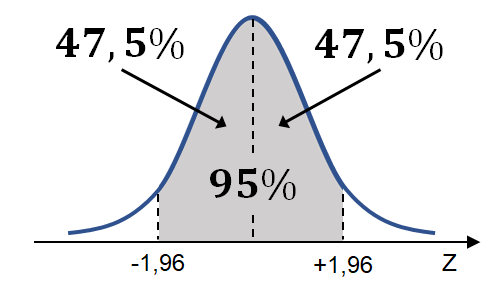

Para obtermos o z, deveremos lembrar de quando estávamos trabalhando com a Distribuição Normal; o z era calculado e tinha toda essa área hachurada abaixo dele. Ou seja, do pico médio da curva para trás, sabemos que vale 0.5.

Porém, ainda tínhamos que calcular deste meio até o z. Como temos uma função simétrica e sabemos que a área sob a curva de um z a outro divididos pela média é de 0.95, deveremos dividir por 2. Logo, saberemos que do meio da curva até o z o valor será de 0.475 ou 47.5%.

Na tabela_normal_padronizada, precisaremos saber qual é o valor todo de um limite Z ao outro, porque a tabela é representada com a área de zero até Z superior.

Obteremos essa probabilidade da área hachurada que não é mais 95%. Contaremos do z positivo até o início, inclusive com o vazio anterior ao z negativo.

A área do z até o meio é igual a 0.475, falta-nos justamente obter a metade 0.5.

Somaremos 0.5 com a divisão de 0.95 por 2.

Uma outra forma de pensar é na seguinte forma:
temos que, por exemplo, toda a área hachurada é 95% e cada área branca é 5%/2. Logo, toda a área abaixo do z é 95% + 5%/2 (que é a área de uma da parte branca de baixo)

In [106]:
confianca / 2

0.475

In [107]:
0.5 + (confianca / 2)

0.975

O resultado será 0.975, ou seja, a área sob a curva normal deste ponto Z superior até o final é de 0.975.

Na tabela, procuraremos o valor 0.975 na linha 1.90 de Z e na coluna 0.06. Como já sabemos, somaremos esses valores e obteremos 1.96.

In [108]:
1.9 + 0.06

1.96

<font color='orange'>Usando o python para obter o $z$</font>

Tenho a probabilidade e quero z (diferente do método cdf que faz o contrário)

In [109]:
z = norm.ppf(0.975)
z

1.959963984540054

#### Valores de $z$ para os níveis de confiança mais utilizados

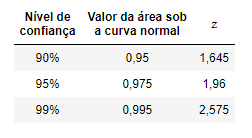

#### <font color='green'>Obtendo o $\sigma_\bar{x}$</font>

In [110]:
desvio_padrao_pop = 150
desvio_padrao_pop

150

In [111]:
n = 20
n

20

In [112]:
raiz_de_n = np.sqrt(n)
raiz_de_n

4.47213595499958

In [113]:
sigma = desvio_padrao_pop / raiz_de_n
sigma

33.54101966249684

#### <font color='green'>Obtendo $e$</font>

In [114]:
e = z * sigma
e

65.73919054324361

#### Solução 1 - Calculando o intervalo de confiança para a média manualmente

In [115]:
intervalo_manual = (
    media_amostral - e, media_amostral + e
)
intervalo_manual

(4984.260809456757, 5115.739190543243)

Temos uma probabilidade de 95% (nível de confiança) do parâmetro da população estar dentro desse intervalo.

#### Solução 2 - Calculando o intervalo de confiança para a média usando o python

In [116]:
intervalo_python = norm.interval(alpha = 0.95, loc = media_amostral, scale = sigma)
intervalo_python

(4984.260809456757, 5115.739190543243)

#### <font color='red'>Problema extra 1</font>
Para estimar o valor médio gasto por cada cliente de uma grande rede de fast-food, foi selecionada uma amostra de 50 clientes.

Assumindo que o valor do desvio padrão da população seja de R$ 6,00 e que esta população se distribui normalmente, obtenha a margem de erro desta estimativa para um nível de confiança de 95%.

In [117]:
n_prob1 = 50
desvio_padrao_pop_prob1 = 6
confianca_prob1 = 0.95

In [118]:
raiz_de_n_prob1 = np.sqrt(n_prob1)
raiz_de_n_prob1

7.0710678118654755

In [119]:
sigma_prob1 = desvio_padrao_pop_prob1 / raiz_de_n_prob1
sigma_prob1

0.848528137423857

In [120]:
z_prob1 = 1.96
z_prob1

1.96

In [121]:
e = z_prob1 * sigma_prob1
e

1.6631151493507597

#### <font color='red'>Problema extra 2</font>

Uma amostra aleatória simples de 1976 itens de uma população normalmente distribuída, com desvio padrão populacional igual a 11, resultou em uma média amostral de 28.

Qual o intervalo de confiança de 90% para a média populacional?

In [122]:
n_prob2 = 1976
desvio_padrao_pop_prob2 = 11
media_amostral_prob2 = 28
confianca = 0.9

In [123]:
z_prob2 = 1.645
z_prob2

1.645

In [124]:
sigma_prob2 = desvio_padrao_pop_prob2 / (np.sqrt(n_prob2))
sigma_prob2

0.24745669886621613

In [125]:
e = z_prob2 * sigma_prob2
e

0.40706626963492554

In [126]:
norm.interval(alpha = 0.90, loc = media_amostral_prob2, scale = sigma_prob2)

(27.592969951356466, 28.407030048643534)

## Cálculo do tamanho da amostra

Cálculo do tamanho da amostra para que ela seja realmente representativa da população a ser estudada.

### Variáveis quantitativas e população infinita

# $$e = z \frac{\sigma}{\sqrt{n}}$$

#### Com desvio padrão conhecido

## $$n = \left(z\frac{\sigma}{e}\right)^2$$

#### Com desvio padrão desconhecido

## $$n = \left(z\frac{s}{e}\right)^2$$

Onde:

$z$ = variável normal padronizada

$\sigma$ = desvio padrão populacional

$s$ = desvio padrão amostral

$e$ = erro inferencial

#### <font color='red'>Observações</font>

1. O desvio padrão ($\sigma$ ou $s$) e o erro ($e$) devem estar na mesma unidade de medida.

2. Quando o erro ($e$) for representado em termos percentuais, deve ser interpretado como um percentual relacionado à média.

#### <font color='red'>Problema</font>

Estamos estudando o rendimento mensal dos chefes de domicílios no Brasil. Nosso supervisor determinou que o **erro máximo em relação a média seja de R$\$$ 100,00**. Sabemos que o **desvio padrão populacional** deste grupo de trabalhadores é de **R$\$$ 3.323,39**. Para um **nível de confiança de 95%**, qual deve ser o tamanho da amostra de nosso estudo?

#### <font color='green'>Obtendo $z$</font>

In [128]:
0.95 + (0.05 / 2)

0.975

In [129]:
z = norm.ppf(0.975)
z

1.959963984540054

#### <font color='green'>Obtendo $\sigma$</font>

In [130]:
sigma = 3323.39
sigma

3323.39

#### <font color='green'>Obtendo $e$</font>

In [131]:
e = 100
e

100

#### <font color='green'>Obtendo $n$</font>

In [132]:
n = (z * (sigma / e)) ** 2
n = int(n.round())
n

4243

#### <font color='red'>Problema extra 1</font>

O valor do gasto médio dos clientes de uma loja de conveniência é de 45,50. Assumindo que o desvio padrão dos gastos é igual a R$ 15,00, qual deve ser o tamanho da amostra para estimarmos a média populacional com um nível de significância de 10%?

Considere que o erro máximo aceitável seja de 10%.

In [133]:
# Obtendo z

0.90 + (0.1 / 2)

0.9500000000000001

In [134]:
z_prob_extra1 = norm.ppf(0.95)
z_prob_extra1

1.6448536269514722

In [135]:
# Obtendo sigma

sigma_prob_extra1 = 15
sigma_prob_extra1

15

In [139]:
# Obtendo o erro
# Observe que foi fornecido em termos percentuais

e_prob_extra1 = 45.5 * 0.1
e_prob_extra1

4.55

In [140]:
n_prob_extra1 = (z_prob_extra1 * (sigma_prob_extra1 / e_prob_extra1)) ** 2
n_prob_extra1 = int(n_prob_extra1.round())
n_prob_extra1

29

### Variáveis quantitativas e população finita

#### Com desvio padrão conhecido

## $$n = \frac{z^2 \sigma^2 N}{z^2 \sigma^2 + e^2(N-1)}$$

#### Com desvio padrão desconhecido

## $$n = \frac{z^2 s^2 N}{z^2 s^2 + e^2(N-1)}$$

Onde:

$N$ = tamanho da população

$z$ = variável normal padronizada

$\sigma$ = desvio padrão populacional

$s$ = desvio padrão amostral

$e$ = erro inferencial

#### <font color='red'>Problema</font>

Em um lote de **10.000 latas** de refrigerante foi realizada uma amostra aleatória simples de **100 latas** e foi obtido o **desvio padrão amostral do conteúdo das latas igual a 12 ml**. O fabricante estipula um **erro máximo sobre a média populacional de apenas 5 ml**. Para garantir um **nível de confiança de 95%** qual o tamanho de amostra deve ser selecionado para este estudo?

#### <font color='green'>Obtendo $N$</font>

In [141]:
N = 10000
N

10000

#### <font color='green'>Obtendo $z$</font>

In [142]:
z = norm.ppf(0.95 + (0.05 /2))
z

1.959963984540054

#### <font color='green'>Obtendo $s$</font>

In [143]:
s = 12
s

12

#### <font color='green'>Obtendo $e$</font>

In [144]:
e = 5
e

5

#### <font color='green'>Obtendo $n$</font>

In [146]:
n = ((z ** 2) * (s ** 2) * (N)) / (((z ** 2) * (s ** 2)) + ((e ** 2) * (N - 1)))
n = int(n.round())
n

22

#### <font color='red'>Problema extra 1</font>

Um fabricante de farinha verificou que, em uma amostra aleatória formada por 200 sacos de 25 kg de um lote formado por 2.000 sacos, apresentou um desvio padrão amostral do peso igual a 480 g.

Considerando um erro máximo associado à média populacional igual a 0,3 kg e um nível de confiança igual a 95%, qual tamanho de amostra deveria ser selecionado para obtermos uma estimativa confiável do parâmetro populacional?

In [147]:
# Obtendo N

N_prob_extra1 = 2000
N_prob_extra1

2000

In [148]:
# Obtendo z

z_prob_extra1 = norm.ppf(0.95 + (0.05 /2))
z_prob_extra1

1.959963984540054

In [150]:
# Obtendo sigma

sigma_prob_extra1 = 0.48 # convertendo g para kg
sigma_prob_extra1

0.48

In [151]:
# Obtendo e

e_prob_extra1 = 0.3
e_prob_extra1

0.3

In [152]:
n_prob_extra1 = ((z_prob_extra1 ** 2) * (sigma_prob_extra1 ** 2) * (N_prob_extra1)) / (((z_prob_extra1 ** 2) * (sigma_prob_extra1 ** 2)) + ((e_prob_extra1 ** 2) * (N_prob_extra1 - 1)))
n_prob_extra1 = int(n_prob_extra1.round())
n_prob_extra1

10

## Mais algumas fixações

### <font color='blue'> Exemplo: rendimento médio</font>

Estamos estudando o **rendimento mensal dos chefes de domicílios com renda até R$\$$ 5.000,00 no Brasil**. Nosso supervisor determinou que o **erro máximo em relação a média seja de R$\$$ 10,00**. Sabemos que o **desvio padrão populacional** deste grupo de trabalhadores é de **R$\$$ 1.082,79** e que a **média populacional** é de **R$\$$ 1.426,54**. Para um **nível de confiança de 95%**, qual deve ser o tamanho da amostra de nosso estudo? Qual o intervalo de confiança para a média considerando o tamanho de amostra obtido?

#### Construindo o dataset conforme especificado pelo problema

In [153]:
renda_5000 = df.query("renda <= 5000").renda
renda_5000.head()

0     800.0
1    1150.0
2     880.0
3    3500.0
4     150.0
Name: renda, dtype: float64

In [164]:
sigma = renda_5000.std()
sigma

1082.794549030635

In [165]:
media = renda_5000.mean()
media

1426.5372144947232

#### Calculando o tamanho da amostra

Assumindo que a população é infinita, pois, aqui, é uma população muito grande.

In [158]:
z = norm.ppf(0.95 + (0.05/2))
z

1.959963984540054

In [159]:
e = 10
e

10

In [166]:
n = (z * (sigma / e)) ** 2
n = int(n.round())
n

45039

#### Calculando o intervalo de confiança para a média

In [167]:
intervalo = norm.interval(alpha = 0.95, loc = media, scale = sigma / np.sqrt(n))
intervalo

(1416.5372195108241, 1436.5372094786223)

#### Realizando uma prova gráfica

<AxesSubplot:>

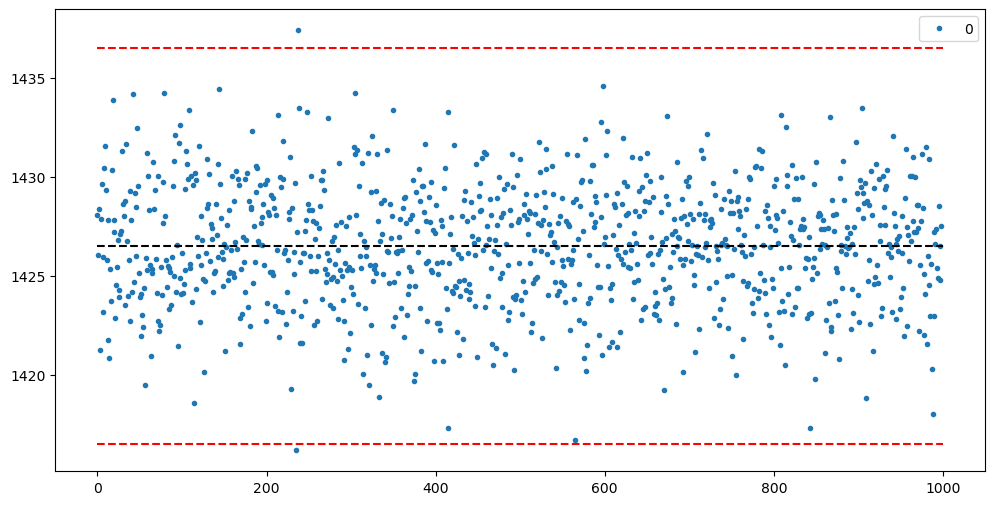

In [170]:
import matplotlib.pyplot as plt

tamanho_simulacao = 1000 # 1000 amostragens com n 45039

medias = [renda_5000.sample(n = n).mean() for i in range(1, tamanho_simulacao)]
medias = pd.DataFrame(medias)

ax = medias.plot(style = '.')
ax.figure.set_size_inches(12, 6)
ax.hlines(y = media, xmin = 0, xmax = tamanho_simulacao, colors='black', linestyles='dashed') # média
ax.hlines(y = intervalo[0], xmin = 0, xmax = tamanho_simulacao, colors='red', linestyles='dashed') # limite inferior do intervalo
ax.hlines(y = intervalo[1], xmin = 0, xmax = tamanho_simulacao, colors='red', linestyles='dashed') # limite superior do intervalo
ax

Observe que a imensa maioria dos pontos caem dentro do intervalo de confiança. Melhor, temos 95% de probabilidade dos valores caírem dentro do intervalo.